In [1]:

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from sklearn.model_selection import train_test_split

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau


import random
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# Image dimensions
IMAGE_SIZE = (224, 224)  # Standard size for many pre-trained CNNs

# Training parameters
BATCH_SIZE = 32
EPOCHS = 20
LEARNING_RATE = 0.0001

# Data splitting
VALIDATION_SPLIT = 0.15
TEST_SPLIT = 0.15

# Paths
BASE_PATH = "../rare_species_1"
METADATA_PATH = "../metadata.csv"

# Minimum samples required per class
MIN_SAMPLES_PER_CLASS = 10

# Load the CSV file
metadata = pd.read_csv(METADATA_PATH, skipinitialspace=True)

# Clean column names (remove any leading/trailing spaces)
metadata.columns = metadata.columns.str.strip()



In [2]:
# Display basic information
print(f"Dataset contains {len(metadata)} images")
display(metadata.head())

# Check columns
print(f"\nColumns in the dataset: {', '.join(metadata.columns)}")

# Explore the distribution of families (classes)
print("\nClass distribution:")
family_counts = metadata['family'].value_counts()
print(f"Number of unique families: {len(family_counts)}")
print(f"Most common family: {family_counts.index[0]} with {family_counts.iloc[0]} images")
print(f"Least common family: {family_counts.index[-1]} with {family_counts.iloc[-1]} images")



Dataset contains 11983 images


,rare_species_id,eol_content_id,eol_page_id,kingdom,phylum,family,file_path
0,75fd91cb-2881-41cd-88e6-de451e8b60e2,12853737,449393,animalia,mollusca,unionidae,mollusca_unionidae/12853737_449393_eol-full-si...
1,28c508bc-63ff-4e60-9c8f-1934367e1528,20969394,793083,animalia,chordata,geoemydidae,chordata_geoemydidae/20969394_793083_eol-full-...
2,00372441-588c-4af8-9665-29bee20822c0,28895411,319982,animalia,chordata,cryptobranchidae,chordata_cryptobranchidae/28895411_319982_eol-...
3,29cc6040-6af2-49ee-86ec-ab7d89793828,29658536,45510188,animalia,chordata,turdidae,chordata_turdidae/29658536_45510188_eol-full-s...
4,94004bff-3a33-4758-8125-bf72e6e57eab,21252576,7250886,animalia,chordata,indriidae,chordata_indriidae/21252576_7250886_eol-full-s...



Columns in the dataset: rare_species_id, eol_content_id, eol_page_id, kingdom, phylum, family, file_path

Class distribution:
Number of unique families: 202
Most common family: cercopithecidae   with 300 images
Least common family: siluridae         with 29 images


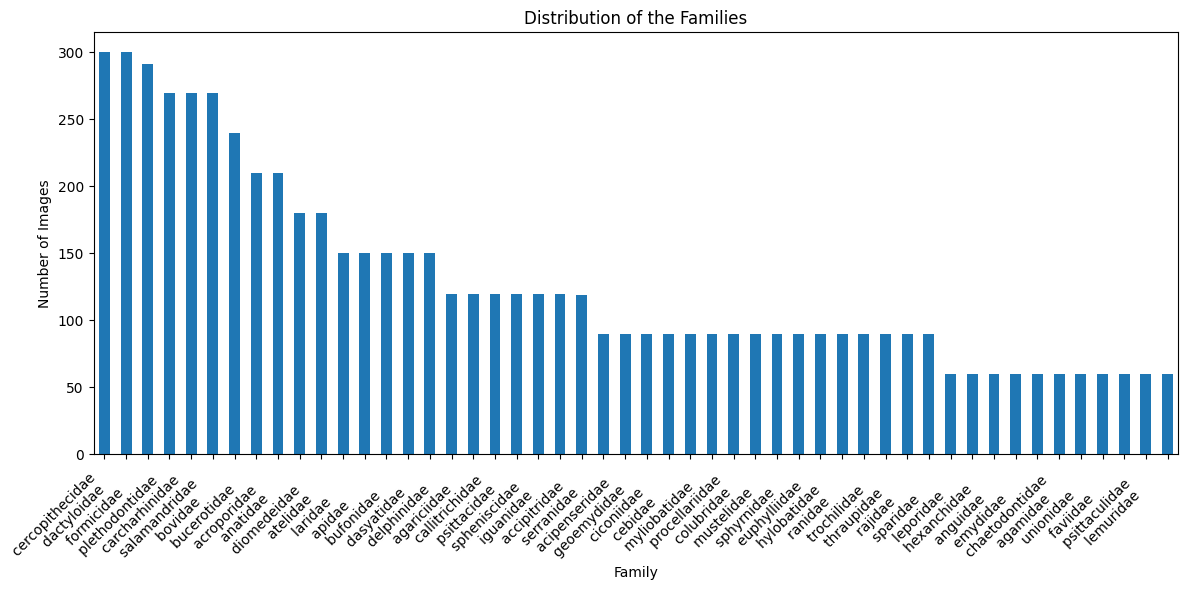

In [3]:
# Plot the distribution of top 15 families
plt.figure(figsize=(12, 6))
family_counts.head(50).plot(kind='bar')
plt.title('Distribution of the Families')
plt.xlabel('Family')
plt.ylabel('Number of Images')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

No flitering out of any families because lowest sample set has 29 pictures

In [4]:

# We'll only keep families with at least MIN_SAMPLES_PER_CLASS images
valid_families = family_counts[family_counts >= MIN_SAMPLES_PER_CLASS].index.tolist()

print(f"Keeping {len(valid_families)} families with at least {MIN_SAMPLES_PER_CLASS} samples")
print(f"Removing {len(family_counts) - len(valid_families)} families with fewer than {MIN_SAMPLES_PER_CLASS} samples")

# Filter the metadata to only include the valid families
filtered_metadata = metadata[metadata['family'].isin(valid_families)]
print(f"Dataset reduced from {len(metadata)} to {len(filtered_metadata)} samples after filtering")

# Update family counts after filtering
filtered_family_counts = filtered_metadata['family'].value_counts()
print(f"Number of unique families after filtering: {len(filtered_family_counts)}")


Keeping 202 families with at least 10 samples
Removing 0 families with fewer than 10 samples
Dataset reduced from 11983 to 11983 samples after filtering
Number of unique families after filtering: 202


## Splitting the data


In [5]:
train_val_data, test_data = train_test_split(
    filtered_metadata, 
    test_size=TEST_SPLIT, 
    stratify=filtered_metadata['family'],
    random_state=42
)

# Then split the remaining data into train and validation
train_data, val_data = train_test_split(
    train_val_data, 
    test_size=VALIDATION_SPLIT,
    stratify=train_val_data['family'],
    random_state=42
)

print(f"Train set: {len(train_data)} samples")
print(f"Validation set: {len(val_data)} samples")
print(f"Test set: {len(test_data)} samples")


Train set: 8657 samples
Validation set: 1528 samples
Test set: 1798 samples


# Label encoding

Neural networks don’t understand words they only work with numbers. That’s why we have to change our family names, like “Asteraceae” or “Fabaceae,” into numbers first. This is called label encoding.


In [6]:
families = sorted(filtered_metadata['family'].unique())
family_to_idx = {family: idx for idx, family in enumerate(families)}
idx_to_family = {idx: family for family, idx in family_to_idx.items()}


Testing image preprocessing with: ../rare_species_1/mollusca_unionidae/12853737_449393_eol-full-size-copy.jpg
Successfully processed image. Shape: (224, 224, 3)


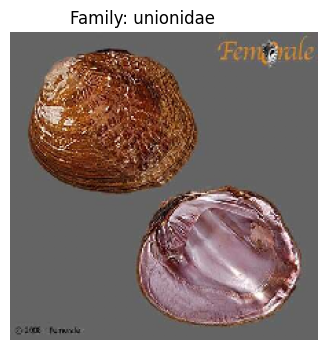

In [7]:
def preprocess_image(image_path, target_size=IMAGE_SIZE):
    """Load and preprocess a single image"""
    try:
        # Load the image
        img = load_img(image_path, target_size=target_size)
        
        # Convert to array and normalize to [0, 1]
        img_array = img_to_array(img)
        img_array = img_array / 255.0
        
        return img_array
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        return None

# Test the function with a sample image
sample_image_path = os.path.join(BASE_PATH, filtered_metadata.iloc[0]['file_path'])
print(f"Testing image preprocessing with: {sample_image_path}")
sample_processed = preprocess_image(sample_image_path)

if sample_processed is not None:
    print(f"Successfully processed image. Shape: {sample_processed.shape}")
    # Display the processed image
    plt.figure(figsize=(4, 4))
    plt.imshow(sample_processed)
    plt.title(f"Family: {filtered_metadata.iloc[0]['family']}")
    plt.axis('off')
    plt.show()
else:
    print("Failed to process the sample image")

In [8]:
print("Loading training data...")
X_train = []
y_train = []

# Process training images with a progress counter
for idx, row in train_data.iterrows():
    if idx % 100 == 0:
        print(f"Processing image {idx}/{len(train_data)}")
    
    # Construct the full image path
    img_path = os.path.join(BASE_PATH, row['file_path'])
    
    # Load and preprocess the image
    img_array = preprocess_image(img_path)
    
    if img_array is not None:
        # Get the label
        label = family_to_idx[row['family']]
        
        X_train.append(img_array)
        y_train.append(label)

# Convert to numpy arrays
X_train = np.array(X_train)
y_train = to_categorical(y_train, num_classes=len(family_to_idx))

print(f"Loaded {len(X_train)} training images with shape {X_train.shape}")
print(f"Training labels shape: {y_train.shape}")

Loading training data...


Processing image 9400/8657
Processing image 7000/8657
Processing image 2500/8657
Processing image 3900/8657
Processing image 4800/8657
Processing image 4100/8657
Processing image 6300/8657
Processing image 8600/8657
Processing image 900/8657
Processing image 10900/8657
Processing image 4700/8657
Processing image 2700/8657
Processing image 2800/8657
Processing image 5000/8657
Processing image 8900/8657
Processing image 7300/8657
Processing image 7600/8657
Processing image 1700/8657
Processing image 0/8657
Processing image 9500/8657
Processing image 7900/8657
Processing image 8100/8657
Processing image 9000/8657
Processing image 6500/8657
Processing image 9700/8657
Processing image 6700/8657
Processing image 10000/8657
Processing image 8200/8657
Processing image 5700/8657
Processing image 200/8657
Processing image 3700/8657
Processing image 7800/8657
Processing image 1800/8657
Processing image 8400/8657
Processing image 100/8657
Processing image 600/8657
Processing image 8500/8657
Proces

/Users/benerugg/DataScience/deepLearning/github/deep_learning/venv/lib/python3.11/site-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Processing image 1500/8657
Processing image 11800/8657
Processing image 5400/8657
Processing image 1900/8657
Processing image 10200/8657
Processing image 2900/8657
Processing image 3800/8657
Processing image 4300/8657
Processing image 11600/8657
Processing image 3300/8657
Processing image 10800/8657
Processing image 6100/8657
Processing image 7200/8657
Processing image 11200/8657
Processing image 3500/8657
Processing image 500/8657
Processing image 6600/8657
Processing image 5300/8657
Processing image 10100/8657
Processing image 3600/8657
Processing image 11300/8657
Processing image 11500/8657
Processing image 8300/8657
Loaded 8657 training images with shape (8657, 224, 224, 3)
Training labels shape: (8657, 202)


In [9]:
print("\nLoading validation data...")
X_val = []
y_val = []

for idx, row in val_data.iterrows():
    if idx % 100 == 0:
        print(f"Processing image {idx}/{len(val_data)}")
    
    img_path = os.path.join(BASE_PATH, row['file_path'])
    img_array = preprocess_image(img_path)
    
    if img_array is not None:
        label = family_to_idx[row['family']]
        X_val.append(img_array)
        y_val.append(label)

X_val = np.array(X_val)
y_val = to_categorical(y_val, num_classes=len(family_to_idx))

print(f"Loaded {len(X_val)} validation images with shape {X_val.shape}")
print(f"Validation labels shape: {y_val.shape}")


Loading validation data...
Processing image 6000/1528
Processing image 400/1528
Processing image 11400/1528
Processing image 7400/1528
Processing image 11100/1528
Processing image 11700/1528
Processing image 9800/1528
Processing image 5500/1528
Processing image 3000/1528
Processing image 9100/1528
Processing image 8800/1528
Processing image 7100/1528
Processing image 2100/1528
Processing image 6900/1528
Processing image 1100/1528
Processing image 9200/1528
Processing image 2000/1528
Processing image 6800/1528
Processing image 4400/1528
Loaded 1528 validation images with shape (1528, 224, 224, 3)
Validation labels shape: (1528, 202)


In [10]:
print("\nLoading test data...")
X_test = []
y_test = []

for idx, row in test_data.iterrows():
    if idx % 100 == 0:
        print(f"Processing image {idx}/{len(test_data)}")
    
    img_path = os.path.join(BASE_PATH, row['file_path'])
    img_array = preprocess_image(img_path)
    
    if img_array is not None:
        label = family_to_idx[row['family']]
        X_test.append(img_array)
        y_test.append(label)

X_test = np.array(X_test)
y_test = to_categorical(y_test, num_classes=len(family_to_idx))

print(f"Loaded {len(X_test)} test images with shape {X_test.shape}")
print(f"Test labels shape: {y_test.shape}")



Loading test data...
Processing image 7500/1798
Processing image 9300/1798
Processing image 4200/1798
Processing image 1000/1798
Processing image 6200/1798
Processing image 10400/1798
Processing image 1300/1798
Processing image 5800/1798
Processing image 1200/1798
Processing image 5900/1798
Processing image 300/1798
Processing image 6400/1798
Processing image 700/1798
Processing image 11000/1798
Processing image 4600/1798
Loaded 1798 test images with shape (1798, 224, 224, 3)
Test labels shape: (1798, 202)


In [49]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=VALIDATION_SPLIT
)


# Fit the data generator on our training data
datagen.fit(X_train)

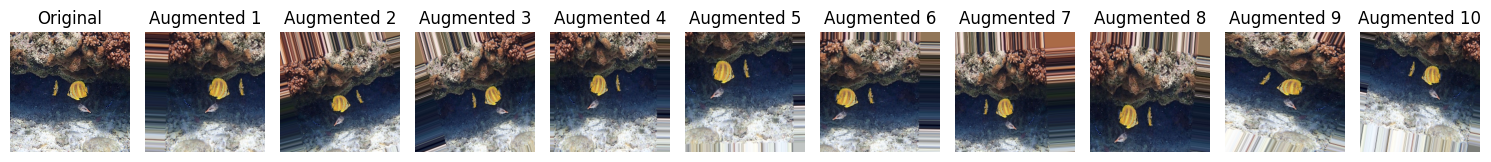

In [66]:
def visualize_augmentation(X, datagen, num_examples=10):
    """Visualize examples of augmented images"""
    # Get a sample image
    sample_image = X[0]
    sample_image = np.expand_dims(sample_image, 0)  # Add batch dimension
    
    # Generate augmented images
    aug_iter = datagen.flow(sample_image, batch_size=1)
    aug_images = [sample_image[0]]  # Original image
    
    # Get augmented samples
    for _ in range(num_examples):
        aug_images.append(next(aug_iter)[0])
    
    # Plot
    plt.figure(figsize=(15, 3))
    plt.subplot(1, num_examples+1, 1)
    plt.imshow(aug_images[0])
    plt.title("Original")
    plt.axis("off")
    
    for i in range(num_examples):
        plt.subplot(1, num_examples+1, i+2)
        plt.imshow(aug_images[i+1])
        plt.title(f"Augmented {i+1}")
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()

# Visualize some augmented examples
visualize_augmentation(X_train, datagen)

In [13]:
# Cell 13: Build the model using transfer learning
print("Building the model with ResNet50 as the base...")

# We'll use a pre-trained model as the base (transfer learning)
base_model = ResNet50(weights='imagenet', 
                     include_top=False, 
                     input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom top layers for our classification task
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(family_to_idx), activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Show a summary of the model
model.summary()

Building the model with ResNet50 as the base...
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,740,426 (94.38 MB)

 Trainable params: 1,152,714 (4.40 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [14]:
# Checkpoint to save the best model
checkpoint = ModelCheckpoint(
    'best_model.h5', 
    monitor='val_accuracy', 
    verbose=1, 
    save_best_only=True, 
    mode='max'
)

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Reduce learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-6
)

callbacks = [checkpoint, early_stopping, reduce_lr]

In [15]:
print("Training the model...")

# For this example, we'll use a small number of epochs
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
    epochs=EPOCHS,
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    verbose=1
)

Training the model...


/Users/benerugg/DataScience/deepLearning/github/deep_learning/venv/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
271/271 ━━━━━━━━━━━━━━━━━━━━ 0s 562ms/step - accuracy: 0.0150 - loss: 5.3958
Epoch 1: val_accuracy improved from -inf to 0.03403, saving model to best_model.h5


271/271 ━━━━━━━━━━━━━━━━━━━━ 182s 663ms/step - accuracy: 0.0150 - loss: 5.3952 - val_accuracy: 0.0340 - val_loss: 5.0486 - learning_rate: 1.0000e-04
Epoch 2/20
271/271 ━━━━━━━━━━━━━━━━━━━━ 0s 548ms/step - accuracy: 0.0292 - loss: 5.0953
Epoch 2: val_accuracy improved from 0.03403 to 0.03730, saving model to best_model.h5


271/271 ━━━━━━━━━━━━━━━━━━━━ 175s 644ms/step - accuracy: 0.0292 - loss: 5.0953 - val_accuracy: 0.0373 - val_loss: 5.0152 - learning_rate: 1.0000e-04
Epoch 3/20
271/271 ━━━━━━━━━━━━━━━━━━━━ 0s 551ms/step - accuracy: 0.0283 - loss: 5.0672
Epoch 3: val_accuracy improved from 0.03730 to 0.03796, saving model to best_model.h5


271/271 ━━━━━━━━━━━━━━━━━━━━ 176s 649ms/step - accuracy: 0.0283 - loss: 5.0672 - val_accuracy: 0.0380 - val_loss: 4.9971 - learning_rate: 1.0000e-04
Epoch 4/20
271/271 ━━━━━━━━━━━━━━━━━━━━ 0s 544ms/step - accuracy: 0.0307 - loss: 5.0380
Epoch 4: val_accuracy improved from 0.03796 to 0.03861, saving model to best_model.h5


271/271 ━━━━━━━━━━━━━━━━━━━━ 173s 639ms/step - accuracy: 0.0307 - loss: 5.0379 - val_accuracy: 0.0386 - val_loss: 4.9876 - learning_rate: 1.0000e-04
Epoch 5/20
271/271 ━━━━━━━━━━━━━━━━━━━━ 0s 553ms/step - accuracy: 0.0393 - loss: 5.0080
Epoch 5: val_accuracy improved from 0.03861 to 0.03992, saving model to best_model.h5


271/271 ━━━━━━━━━━━━━━━━━━━━ 176s 650ms/step - accuracy: 0.0393 - loss: 5.0080 - val_accuracy: 0.0399 - val_loss: 4.9676 - learning_rate: 1.0000e-04
Epoch 6/20
271/271 ━━━━━━━━━━━━━━━━━━━━ 0s 552ms/step - accuracy: 0.0337 - loss: 4.9929
Epoch 6: val_accuracy improved from 0.03992 to 0.04188, saving model to best_model.h5


271/271 ━━━━━━━━━━━━━━━━━━━━ 175s 647ms/step - accuracy: 0.0337 - loss: 4.9929 - val_accuracy: 0.0419 - val_loss: 4.9547 - learning_rate: 1.0000e-04
Epoch 7/20
271/271 ━━━━━━━━━━━━━━━━━━━━ 0s 551ms/step - accuracy: 0.0371 - loss: 4.9750
Epoch 7: val_accuracy improved from 0.04188 to 0.04908, saving model to best_model.h5


271/271 ━━━━━━━━━━━━━━━━━━━━ 176s 649ms/step - accuracy: 0.0371 - loss: 4.9751 - val_accuracy: 0.0491 - val_loss: 4.9414 - learning_rate: 1.0000e-04
Epoch 8/20
271/271 ━━━━━━━━━━━━━━━━━━━━ 0s 549ms/step - accuracy: 0.0337 - loss: 4.9675
Epoch 8: val_accuracy improved from 0.04908 to 0.05497, saving model to best_model.h5


271/271 ━━━━━━━━━━━━━━━━━━━━ 175s 644ms/step - accuracy: 0.0338 - loss: 4.9675 - val_accuracy: 0.0550 - val_loss: 4.9316 - learning_rate: 1.0000e-04
Epoch 9/20
271/271 ━━━━━━━━━━━━━━━━━━━━ 0s 545ms/step - accuracy: 0.0348 - loss: 4.9461
Epoch 9: val_accuracy did not improve from 0.05497
271/271 ━━━━━━━━━━━━━━━━━━━━ 174s 641ms/step - accuracy: 0.0348 - loss: 4.9461 - val_accuracy: 0.0543 - val_loss: 4.9270 - learning_rate: 1.0000e-04
Epoch 10/20
271/271 ━━━━━━━━━━━━━━━━━━━━ 0s 561ms/step - accuracy: 0.0348 - loss: 4.9493
Epoch 10: val_accuracy did not improve from 0.05497
271/271 ━━━━━━━━━━━━━━━━━━━━ 179s 659ms/step - accuracy: 0.0348 - loss: 4.9492 - val_accuracy: 0.0445 - val_loss: 4.9189 - learning_rate: 1.0000e-04
Epoch 11/20
271/271 ━━━━━━━━━━━━━━━━━━━━ 0s 547ms/step - accuracy: 0.0385 - loss: 4.9502
Epoch 11: val_accuracy improved from 0.05497 to 0.05694, saving model to best_model.h5


271/271 ━━━━━━━━━━━━━━━━━━━━ 174s 643ms/step - accuracy: 0.0385 - loss: 4.9501 - val_accuracy: 0.0569 - val_loss: 4.9075 - learning_rate: 1.0000e-04
Epoch 12/20
271/271 ━━━━━━━━━━━━━━━━━━━━ 0s 546ms/step - accuracy: 0.0382 - loss: 4.9205
Epoch 12: val_accuracy did not improve from 0.05694
271/271 ━━━━━━━━━━━━━━━━━━━━ 174s 642ms/step - accuracy: 0.0382 - loss: 4.9205 - val_accuracy: 0.0537 - val_loss: 4.9032 - learning_rate: 1.0000e-04
Epoch 13/20
271/271 ━━━━━━━━━━━━━━━━━━━━ 0s 547ms/step - accuracy: 0.0406 - loss: 4.9210
Epoch 13: val_accuracy did not improve from 0.05694
271/271 ━━━━━━━━━━━━━━━━━━━━ 174s 642ms/step - accuracy: 0.0406 - loss: 4.9210 - val_accuracy: 0.0497 - val_loss: 4.8981 - learning_rate: 1.0000e-04
Epoch 14/20
271/271 ━━━━━━━━━━━━━━━━━━━━ 0s 613ms/step - accuracy: 0.0432 - loss: 4.9154
Epoch 14: val_accuracy did not improve from 0.05694
271/271 ━━━━━━━━━━━━━━━━━━━━ 196s 724ms/step - accuracy: 0.0432 - loss: 4.9154 - val_accuracy: 0.0510 - val_loss: 4.8959 - learnin

271/271 ━━━━━━━━━━━━━━━━━━━━ 174s 640ms/step - accuracy: 0.0365 - loss: 4.8836 - val_accuracy: 0.0615 - val_loss: 4.8912 - learning_rate: 1.0000e-04
Epoch 17/20
271/271 ━━━━━━━━━━━━━━━━━━━━ 0s 547ms/step - accuracy: 0.0414 - loss: 4.8979
Epoch 17: val_accuracy improved from 0.06152 to 0.06348, saving model to best_model.h5


271/271 ━━━━━━━━━━━━━━━━━━━━ 175s 646ms/step - accuracy: 0.0414 - loss: 4.8979 - val_accuracy: 0.0635 - val_loss: 4.8865 - learning_rate: 1.0000e-04
Epoch 18/20
271/271 ━━━━━━━━━━━━━━━━━━━━ 0s 544ms/step - accuracy: 0.0377 - loss: 4.8762
Epoch 18: val_accuracy did not improve from 0.06348
271/271 ━━━━━━━━━━━━━━━━━━━━ 173s 638ms/step - accuracy: 0.0377 - loss: 4.8762 - val_accuracy: 0.0576 - val_loss: 4.8827 - learning_rate: 1.0000e-04
Epoch 19/20
271/271 ━━━━━━━━━━━━━━━━━━━━ 0s 550ms/step - accuracy: 0.0424 - loss: 4.8766
Epoch 19: val_accuracy did not improve from 0.06348
271/271 ━━━━━━━━━━━━━━━━━━━━ 175s 645ms/step - accuracy: 0.0424 - loss: 4.8767 - val_accuracy: 0.0543 - val_loss: 4.8740 - learning_rate: 1.0000e-04
Epoch 20/20
271/271 ━━━━━━━━━━━━━━━━━━━━ 0s 551ms/step - accuracy: 0.0420 - loss: 4.8812
Epoch 20: val_accuracy did not improve from 0.06348
271/271 ━━━━━━━━━━━━━━━━━━━━ 175s 645ms/step - accuracy: 0.0420 - loss: 4.8812 - val_accuracy: 0.0556 - val_loss: 4.8735 - learnin

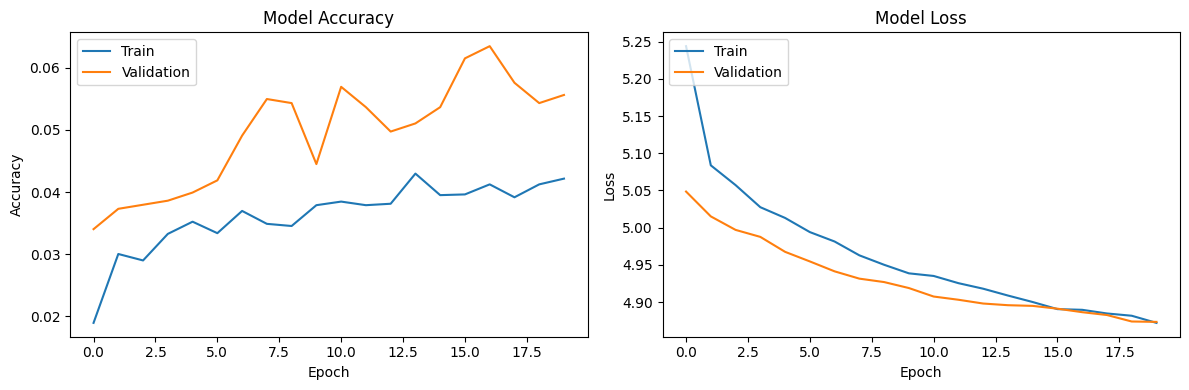

In [16]:
# Plot the training and validation accuracy
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [17]:
print("Evaluating the model on the test set...")
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


Evaluating the model on the test set...
57/57 ━━━━━━━━━━━━━━━━━━━━ 31s 532ms/step - accuracy: 0.0644 - loss: 4.8001
Test Loss: 4.8366
Test Accuracy: 0.0578


In [18]:
# Get predictions on test data
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)


57/57 ━━━━━━━━━━━━━━━━━━━━ 33s 559ms/step


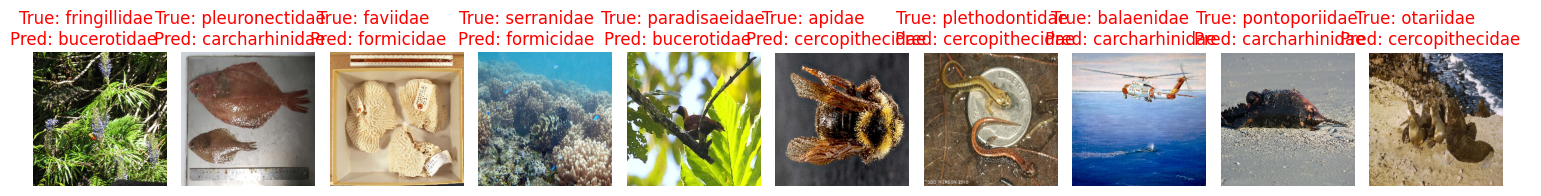

In [73]:
def visualize_predictions(X, y_true, y_pred, idx_to_family, num_samples=10):
    """Visualize some predictions from the model"""
    # Choose random indices
    indices = np.random.choice(range(len(X)), num_samples, replace=False)
    
    plt.figure(figsize=(15, 4))
    for i, idx in enumerate(indices):
        plt.subplot(1, num_samples, i+1)
        plt.imshow(X[idx])
        
        true_class = idx_to_family[y_true[idx]]
        pred_class = idx_to_family[y_pred[idx]]
        title_color = "green" if true_class == pred_class else "red"
        
        plt.title(f"True: {true_class}\nPred: {pred_class}", color=title_color)
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()

# Visualize some predictions
visualize_predictions(X_test, y_true_classes, y_pred_classes, idx_to_family)

In [20]:
print("Fine-tuning the model by unfreezing some layers...")

# Unfreeze some of the layers of the base model
for layer in base_model.layers[-15:]:
    layer.trainable = True

# Recompile the model with a lower learning rate
model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE / 10),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Show the model summary after unfreezing layers
model.summary()

Fine-tuning the model by unfreezing some layers...


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,740,426 (94.38 MB)

 Trainable params: 6,673,098 (25.46 MB)

 Non-trainable params: 18,067,328 (68.92 MB)

In [21]:
# Cell 21: Train the fine-tuned model
history_fine_tune = model.fit(
    datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
    epochs=EPOCHS // 2,  # fewer epochs for fine-tuning
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    verbose=1
)

Epoch 1/10
271/271 ━━━━━━━━━━━━━━━━━━━━ 0s 671ms/step - accuracy: 0.0341 - loss: 5.4204
Epoch 1: val_accuracy did not improve from 0.06348
271/271 ━━━━━━━━━━━━━━━━━━━━ 213s 778ms/step - accuracy: 0.0341 - loss: 5.4191 - val_accuracy: 0.0589 - val_loss: 4.9447 - learning_rate: 1.0000e-05
Epoch 2/10
271/271 ━━━━━━━━━━━━━━━━━━━━ 0s 658ms/step - accuracy: 0.0482 - loss: 4.8524
Epoch 2: val_accuracy improved from 0.06348 to 0.07068, saving model to best_model.h5


271/271 ━━━━━━━━━━━━━━━━━━━━ 204s 754ms/step - accuracy: 0.0482 - loss: 4.8523 - val_accuracy: 0.0707 - val_loss: 4.8232 - learning_rate: 1.0000e-05
Epoch 3/10
271/271 ━━━━━━━━━━━━━━━━━━━━ 0s 661ms/step - accuracy: 0.0517 - loss: 4.8211
Epoch 3: val_accuracy improved from 0.07068 to 0.07657, saving model to best_model.h5


271/271 ━━━━━━━━━━━━━━━━━━━━ 205s 757ms/step - accuracy: 0.0517 - loss: 4.8210 - val_accuracy: 0.0766 - val_loss: 4.7962 - learning_rate: 1.0000e-05
Epoch 4/10
271/271 ━━━━━━━━━━━━━━━━━━━━ 0s 646ms/step - accuracy: 0.0569 - loss: 4.7896
Epoch 4: val_accuracy improved from 0.07657 to 0.07984, saving model to best_model.h5


271/271 ━━━━━━━━━━━━━━━━━━━━ 200s 737ms/step - accuracy: 0.0569 - loss: 4.7895 - val_accuracy: 0.0798 - val_loss: 4.7732 - learning_rate: 1.0000e-05
Epoch 5/10
271/271 ━━━━━━━━━━━━━━━━━━━━ 0s 637ms/step - accuracy: 0.0656 - loss: 4.7480
Epoch 5: val_accuracy improved from 0.07984 to 0.08770, saving model to best_model.h5


271/271 ━━━━━━━━━━━━━━━━━━━━ 197s 728ms/step - accuracy: 0.0656 - loss: 4.7481 - val_accuracy: 0.0877 - val_loss: 4.7500 - learning_rate: 1.0000e-05
Epoch 6/10
271/271 ━━━━━━━━━━━━━━━━━━━━ 0s 710ms/step - accuracy: 0.0655 - loss: 4.7465
Epoch 6: val_accuracy improved from 0.08770 to 0.08901, saving model to best_model.h5


271/271 ━━━━━━━━━━━━━━━━━━━━ 219s 808ms/step - accuracy: 0.0655 - loss: 4.7465 - val_accuracy: 0.0890 - val_loss: 4.7391 - learning_rate: 1.0000e-05
Epoch 7/10
271/271 ━━━━━━━━━━━━━━━━━━━━ 0s 687ms/step - accuracy: 0.0671 - loss: 4.7329
Epoch 7: val_accuracy did not improve from 0.08901
271/271 ━━━━━━━━━━━━━━━━━━━━ 212s 781ms/step - accuracy: 0.0671 - loss: 4.7328 - val_accuracy: 0.0870 - val_loss: 4.7191 - learning_rate: 1.0000e-05
Epoch 8/10
271/271 ━━━━━━━━━━━━━━━━━━━━ 0s 663ms/step - accuracy: 0.0844 - loss: 4.7029
Epoch 8: val_accuracy improved from 0.08901 to 0.09620, saving model to best_model.h5


271/271 ━━━━━━━━━━━━━━━━━━━━ 206s 759ms/step - accuracy: 0.0844 - loss: 4.7029 - val_accuracy: 0.0962 - val_loss: 4.7078 - learning_rate: 1.0000e-05
Epoch 9/10
271/271 ━━━━━━━━━━━━━━━━━━━━ 0s 654ms/step - accuracy: 0.0776 - loss: 4.6895
Epoch 9: val_accuracy improved from 0.09620 to 0.09882, saving model to best_model.h5


271/271 ━━━━━━━━━━━━━━━━━━━━ 203s 749ms/step - accuracy: 0.0776 - loss: 4.6895 - val_accuracy: 0.0988 - val_loss: 4.6841 - learning_rate: 1.0000e-05
Epoch 10/10
271/271 ━━━━━━━━━━━━━━━━━━━━ 0s 658ms/step - accuracy: 0.0875 - loss: 4.6532
Epoch 10: val_accuracy improved from 0.09882 to 0.10144, saving model to best_model.h5


271/271 ━━━━━━━━━━━━━━━━━━━━ 205s 757ms/step - accuracy: 0.0875 - loss: 4.6532 - val_accuracy: 0.1014 - val_loss: 4.6706 - learning_rate: 1.0000e-05


In [22]:
# Cell 22: Evaluate the fine-tuned model
print("Evaluating the fine-tuned model on the test set...")
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Evaluating the fine-tuned model on the test set...
57/57 ━━━━━━━━━━━━━━━━━━━━ 32s 550ms/step - accuracy: 0.1137 - loss: 4.5750
Test Loss: 4.6238
Test Accuracy: 0.0990


In [23]:
# Cell 23: Save the final model
model.save('final_rare_species_classifier.h5')
print("Final model saved to 'final_rare_species_classifier.h5'")

Final model saved to 'final_rare_species_classifier.h5'


In [24]:
# Cell 24: Summary and next steps
print("Summary:")
print(f"- Dataset: {len(filtered_metadata)} images from {len(families)} different families")
print(f"- Data splits: Training ({len(X_train)}), Validation ({len(X_val)}), Test ({len(X_test)})")
print(f"- Final test accuracy: {test_accuracy:.4f}")

print("\nNext steps:")
print("1. Try different pre-trained models (VGG16, InceptionV3, EfficientNet, etc.)")
print("2. Experiment with different data augmentation techniques")
print("3. Use more sophisticated techniques for handling class imbalance")
print("4. Analyze model performance on different families")
print("5. Deploy the model for real-world use")

Summary:
- Dataset: 11983 images from 202 different families
- Data splits: Training (8657), Validation (1528), Test (1798)
- Final test accuracy: 0.0990

Next steps:
1. Try different pre-trained models (VGG16, InceptionV3, EfficientNet, etc.)
2. Experiment with different data augmentation techniques
3. Use more sophisticated techniques for handling class imbalance
4. Analyze model performance on different families
5. Deploy the model for real-world use
